In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk

In [2]:
train = pd.read_csv('twitter_train.csv')
test = pd.read_csv('twitter_test.csv')

print(train.shape)
print(test.shape)

(31962, 3)
(17197, 2)


In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
id       31962 non-null int64
label    31962 non-null int64
tweet    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [5]:
train.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [6]:
train['tweet'].head()

0     @user when a father is dysfunctional and is s...
1    @user @user thanks for #lyft credit i can't us...
2                                  bihday your majesty
3    #model   i love u take with u all the time in ...
4               factsguide: society now    #motivation
Name: tweet, dtype: object

In [7]:
train.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

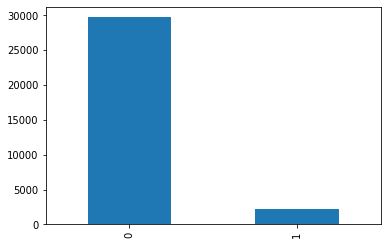

In [8]:
train['label'].value_counts().plot.bar()

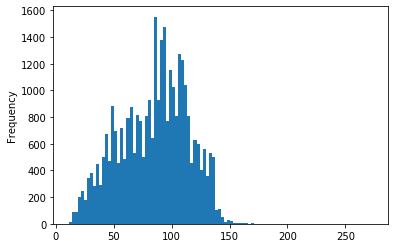

In [9]:
# adding a column to represent the length of the tweet

train['len']=train['tweet'].apply(len)
test['len'] = test['tweet'].apply(len)

# checking the distribution of tweets in the data
train['len'].plot(bins=100, kind='hist')

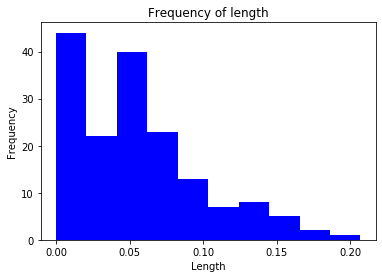

In [10]:
train.groupby('len').mean()['label'].plot.hist(color = 'blue')
plt.title('Frequency of length')
plt.xlabel('Length')
plt.show()

Text(0.5, 1.0, 'Most Frequent Words')

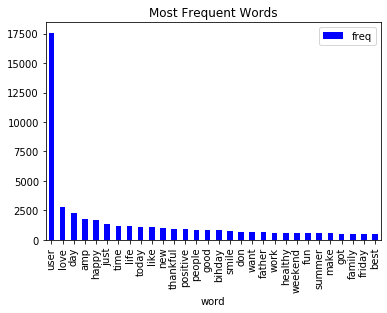

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.tweet)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', color = 'blue')
plt.title("Most Frequent Words")

Text(0.5, 1.0, 'WordCloud for Reviews')

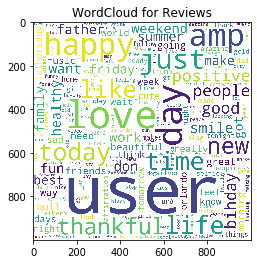

In [12]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure()
#plt.figure(figsize=(10,8))

plt.imshow(wordcloud)
plt.title("WordCloud for Reviews")

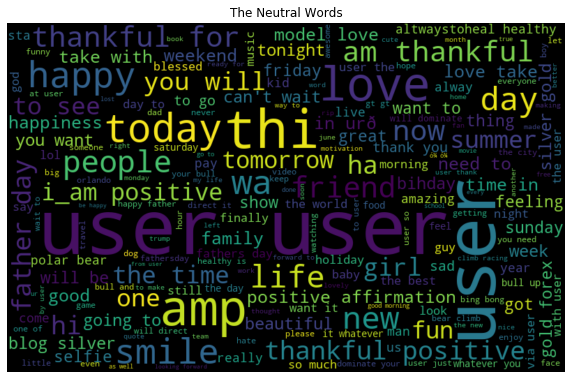

In [13]:
normal_words =' '.join([text for text in train['tweet'][train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

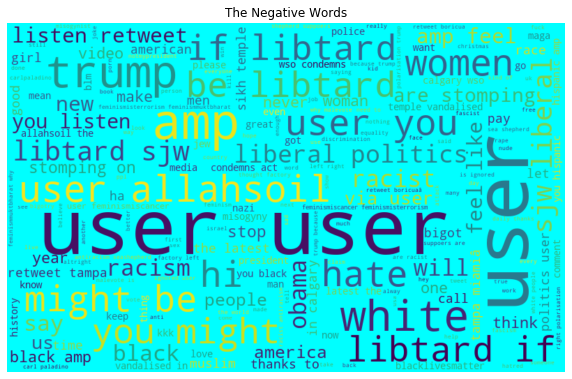

In [14]:
negative_words =' '.join([text for text in train['tweet'][train['label'] == 1]])

wordcloud = WordCloud(background_color = 'cyan', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()


In [15]:
# collecting hashtags
def hashtag_extract(x):
    """
    Function to collect hashtags from tweets
    Input:
    x: the tweet
    Output:
    hashtag: the extracted hashtag(s)
    """
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [16]:
regular = hashtag_extract(train['tweet'][train['label'] == 0])
negative = hashtag_extract(train['tweet'][train['label'] == 1])

regular = sum(regular,[])
negative = sum(negative,[])

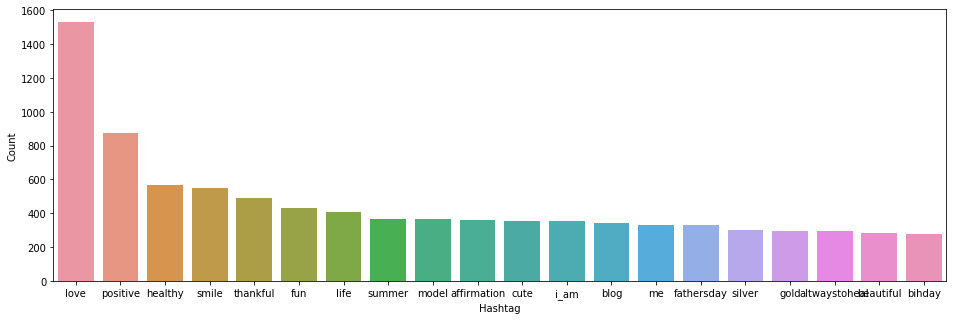

In [17]:
a = nltk.FreqDist(regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

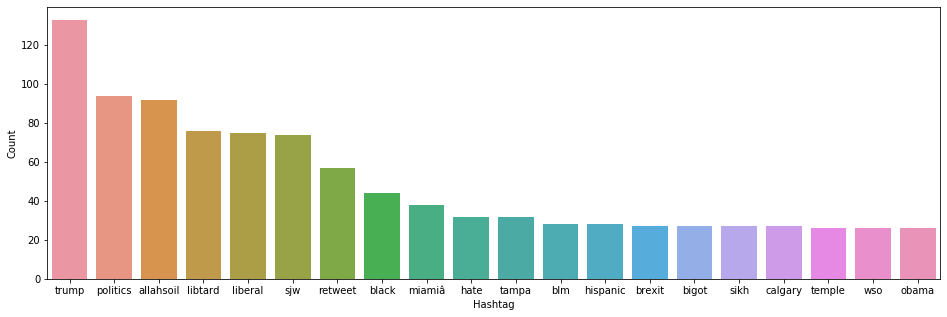

In [18]:
a = nltk.FreqDist(negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [19]:
# tokenization
tokenized_tweet = train['tweet'].apply(lambda x: x.split()) 

import gensim

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(tokenized_tweet, size=200, window=5, min_count=2, sg = 1, hs = 0, negative = 10, workers= 2, seed = 34)
model_w2v.train(tokenized_tweet, total_examples= len(train['tweet']), epochs=20)

C:\Users\dell\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


(6109990, 8411580)

In [20]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence

In [21]:
def add_label(twt):
    """
    Function to label the tweets
    Input:
    twt: the tweet
    Output:
    output: the labeled tweet
    """
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

# label all the tweets
labeled_tweets = add_label(tokenized_tweet)

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  # This is added back by InteractiveShellApp.init_path()


In [22]:
# Stemming the data

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


In [23]:
train_corpus = []

for i in range(0, 31962):
  review = re.sub('[^a-zA-Z]', ' ', train['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  train_corpus.append(review)

In [24]:
test_corpus = []

for i in range(0, 17197):
  review = re.sub('[^a-zA-Z]', ' ', test['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  test_corpus.append(review)

In [25]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(train_corpus).toarray()
y = train.iloc[:, 1]

print(x.shape)
print(y.shape)

(31962, 2500)
(31962,)


In [26]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x_test = cv.fit_transform(test_corpus).toarray()

print(x_test.shape)

(17197, 2500)


In [27]:
# splitting the training data into train and validation sets

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(23971, 2500)
(7991, 2500)
(23971,)
(7991,)


In [28]:
# standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Accuracy : 0.984773267698469
Validation Accuracy : 0.9410586910274058
f1 score : 0.5915004336513443
[[7179  253]
 [ 218  341]]


In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
# Model Generation Using Multinomial Naive Bayes
clf = GaussianNB().fit(x_train, y_train)
predicted= clf.predict(x_valid)
print("MultinomialNB Accuracy:", accuracy_score(y_valid, predicted))
print("f1 score :", f1_score(y_valid, predicted))

MultinomialNB Accuracy: 0.6632461519209111
f1 score : 0.252292303417616


In [31]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred2 = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred2))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred2)
print(cm)

Training Accuracy : 0.9991656585040257
Validation Accuracy : 0.9314228507070454
f1 score : 0.5915004336513443
[[7130  302]
 [ 246  313]]


It is evident that Decision Tree works the best on our dataset.